In [46]:
import importlib
import di_rnn
importlib.reload(di_rnn)

<module 'di_rnn' from 'c:\\Users\\janav\\Documents\\load forecasting\\local-stlf\\di-rnn\\di_rnn.py'>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from di_rnn import DIRNN
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [122]:
def preprocess_data(csv_path, m=4, n=3, freq='30min', splits=(0.6, 0.1, 0.3), horizon=1):
    print("📥 Loading and preprocessing data...")

    # === Load and resample ===
    df = pd.read_csv(csv_path, sep=';', decimal=',')
    df['ts'] = pd.to_datetime(df['ts'])
    df.set_index('ts', inplace=True)
    df = df.sort_index().resample(freq).mean()
    df['vrednost'] = df['vrednost'].interpolate()

    # === Split into train, val, test ===
    total_len = len(df)
    train_end = int(total_len * splits[0])
    val_end = train_end + int(total_len * splits[1])

    df_train = df.iloc[:train_end].copy()
    df_val   = df.iloc[train_end:val_end].copy()
    df_test  = df.iloc[val_end:].copy()

    # === Normalize ===
    print("🔢 Scaling values...")
    scaler = MinMaxScaler()
    df_train['scaled'] = scaler.fit_transform(df_train[['vrednost']])
    df_val['scaled']   = scaler.transform(df_val[['vrednost']])
    df_test['scaled']  = scaler.transform(df_test[['vrednost']])

    df_all = pd.concat([df_train, df_val, df_test])
    values = df_all['scaled']
    timestamps = values.index

    # === Prepare sequences ===
    print("🧩 Constructing input sequences...")
    min_required = max(m, n * int(pd.Timedelta('1D') / pd.to_timedelta(freq)))
    X_seq, X_per, y = [], [], []

    for idx in range(min_required, len(timestamps) - horizon):
        t = timestamps[idx]

        # Short-term input (S-RNN)
        s_start = t - m * pd.to_timedelta(freq)
        s_range = pd.date_range(start=s_start, periods=m, freq=freq)
        if not all(ts in df_all.index for ts in s_range):
            continue
        s_input = df_all.loc[s_range, 'scaled'].values.reshape(m, 1)

        # Periodic input (P-RNN)
        p_input = []
        for i in range(1, n + 1):
            prev_day_time = t - pd.Timedelta(days=i)
            if prev_day_time in df_all.index:
                p_input.append(df_all.loc[prev_day_time, 'scaled'])
            else:
                break
        if len(p_input) != n:
            continue
        p_input = np.array(p_input).reshape(n, 1)

        # Horizon target
        y_start = s_range[-1] + pd.to_timedelta(freq)
        y_range = pd.date_range(start=y_start, periods=horizon, freq=freq)
        if not all(ts in df_all.index for ts in y_range):
            continue
        y_output = df_all.loc[y_range, 'scaled'].values

        X_seq.append(s_input)
        X_per.append(p_input)
        y.append(y_output)

    # === Convert to arrays ===
    X_seq = np.array(X_seq)
    X_per = np.array(X_per)
    y = np.array(y)

    # === Final splits ===
    total_samples = len(y)
    train_end = int(total_samples * splits[0])
    val_end = train_end + int(total_samples * splits[1])

    print(f"✅ Dataset sizes → Train: {train_end}, Val: {val_end - train_end}, Test: {total_samples - val_end}")

    data = {
        'train': (X_seq[:train_end], X_per[:train_end], y[:train_end]),
        'val':   (X_seq[train_end:val_end], X_per[train_end:val_end], y[train_end:val_end]),
        'test':  (X_seq[val_end:], X_per[val_end:], y[val_end:])
    }

    return data, scaler, df_all


In [16]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps

    def forward(self, y_pred, y_true):
        se = (y_true - y_pred) ** 2
        return torch.sqrt(torch.mean(se) + self.eps)


In [54]:
def train_component(model, component_name, x_seq, x_per, y_true, val_data,
                    epochs, lr, device='cpu', patience=5, min_epochs=10):

    print(f"\n🧠 Training {component_name}...")
    criterion = RMSELoss()

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the specific component
    component = getattr(model, component_name)
    for param in component.parameters():
        param.requires_grad = True

    optimizer = torch.optim.Adam(component.parameters(), lr=lr)
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        if component_name == 's_rnn':
            pred = model.s_rnn(x_seq)
        elif component_name == 'p_rnn':
            pred = model.p_rnn(x_per)
        else:
            pred = model(x_seq, x_per)  # goes through both RNNs and bpnn

        loss = criterion(pred, y_true)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            x_seq_val, x_per_val, y_val = val_data
            if component_name == 's_rnn':
                val_pred = model.s_rnn(x_seq_val)
            elif component_name == 'p_rnn':
                val_pred = model.p_rnn(x_per_val)
            else:
                val_pred = model(x_seq_val, x_per_val)

            val_loss = criterion(val_pred, y_val)

        print(f"\r📘 [{component_name}] Epoch {epoch+1}/{epochs} — Train Loss: {loss.item():.6f} | Val Loss: {val_loss.item():.6f}", end="\r")

        if epoch < min_epochs:
            continue
        
        if val_loss.item() < best_val_loss - 1e-5:
            best_val_loss = val_loss.item()
            best_model_state = component.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\r⏹️ Early stopping {component_name} at epoch {epoch+1}. Best Val Loss: {best_val_loss:.6f}", end="\r")
                break

    if best_model_state:
        component.load_state_dict(best_model_state)


In [55]:
def train_dirnn(model, train_data, val_data, epochs=20, lr_rnn=0.005, lr_bpnn=0.008, device='cpu', patience=5, min_epochs=10):
    print("🚂 Starting full DI-RNN training...")
    model = model.to(device)

    X_seq_train, X_per_train, y_train = [torch.tensor(x, dtype=torch.float32).to(device) for x in train_data]
    X_seq_val, X_per_val, y_val = [torch.tensor(x, dtype=torch.float32).to(device) for x in val_data]

    print("Train target shape:", y_train.shape)
    print("Train pred shape:  ", model(X_seq_train, X_per_train).shape)

    val_tensors = (X_seq_val, X_per_val, y_val)

    # === Train each component ===
    train_component(model, 's_rnn', X_seq_train, X_per_train, y_train, val_tensors, epochs, lr_rnn, device, patience, min_epochs)
    train_component(model, 'p_rnn', X_seq_train, X_per_train, y_train, val_tensors, epochs, lr_rnn, device, patience, min_epochs)
    train_component(model, 'bpnn',  X_seq_train, X_per_train, y_train, val_tensors, epochs, lr_bpnn, device, patience, min_epochs)

    return model

In [56]:
samples = [(96, 2), (192, 4), (288, 6), (384, 8)]
horizon = 6

In [57]:
device = "cpu"
device

'cpu'



🔍 Training with m=96, n=2, horizon=6...
📥 Loading and preprocessing data...
🔢 Scaling values...
🧩 Constructing input sequences...
✅ Dataset sizes → Train: 18097, Val: 3016, Test: 9049
🧠 Initializing DIRNN model...
🚂 Starting full DI-RNN training...
Train target shape: torch.Size([18097, 6])
Train pred shape:   torch.Size([18097, 6])

🧠 Training s_rnn...
⏹️ Early stopping s_rnn at epoch 14. Best Val Loss: 0.140379.156119
🧠 Training p_rnn...
⏹️ Early stopping p_rnn at epoch 16. Best Val Loss: 0.133436.145611
🧠 Training bpnn...
⏹️ Early stopping bpnn at epoch 15. Best Val Loss: 0.134536.144259
 Shapes: (9049, 6), (9049, 6)

📊 Evaluation Metrics:
✅ MAE:  1.2264
✅ MSE:  3.1922
✅ MAPE: 0.7226
8.398702 0.18375


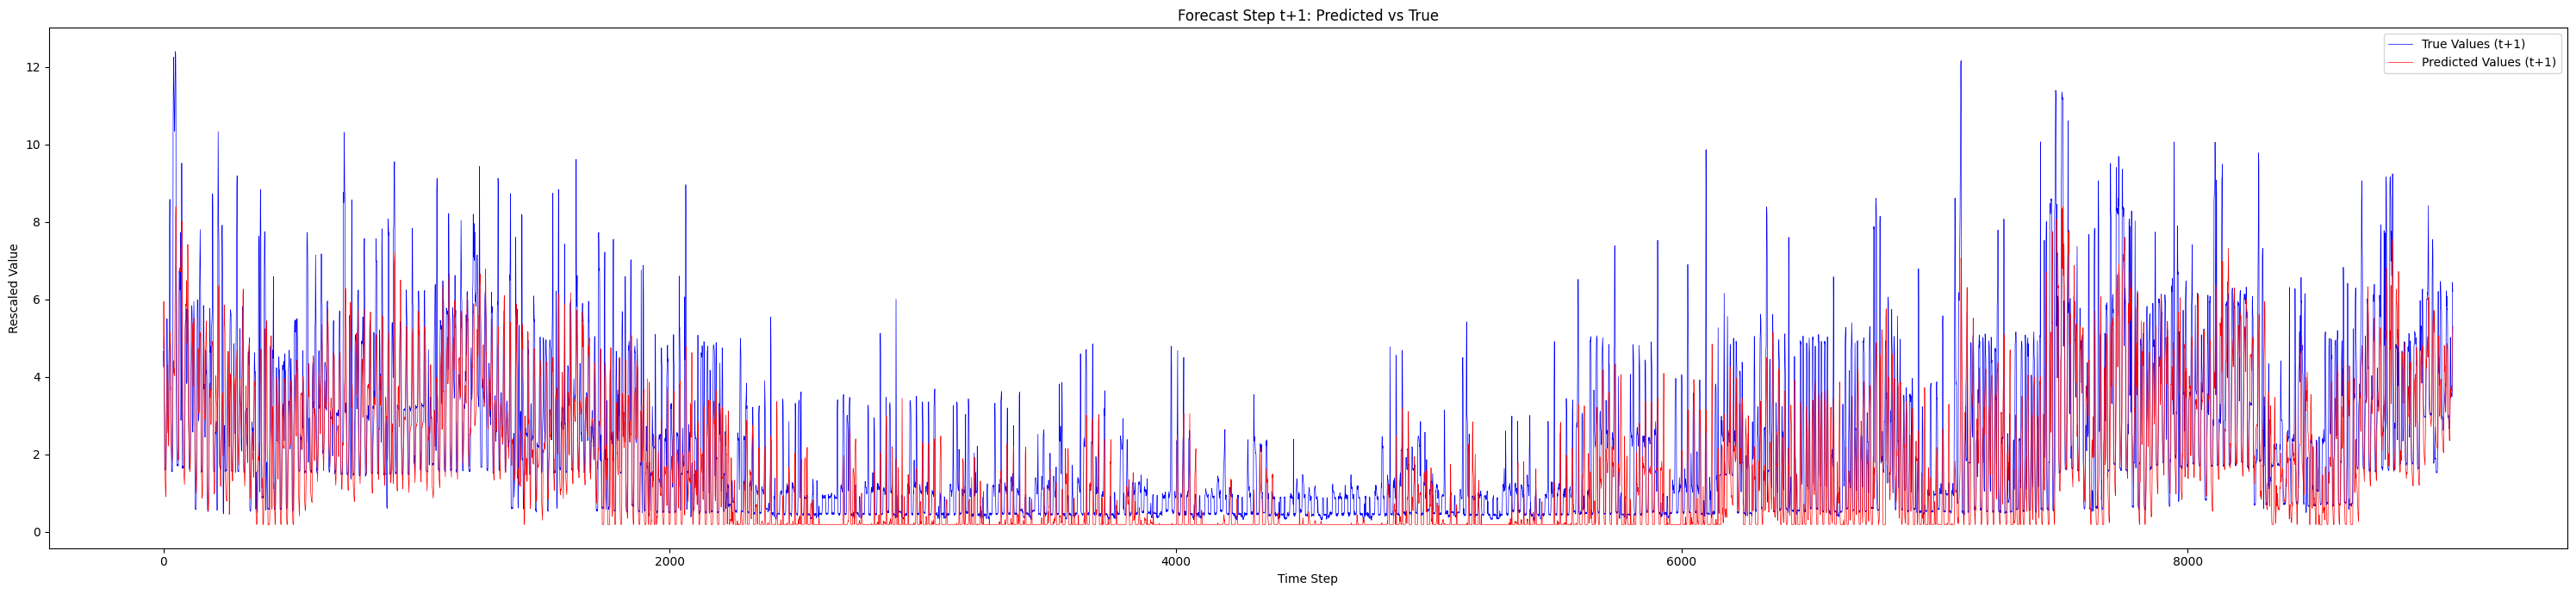



🔍 Training with m=192, n=4, horizon=6...
📥 Loading and preprocessing data...
🔢 Scaling values...
🧩 Constructing input sequences...
✅ Dataset sizes → Train: 18039, Val: 3006, Test: 9021
🧠 Initializing DIRNN model...
🚂 Starting full DI-RNN training...
Train target shape: torch.Size([18039, 6])
Train pred shape:   torch.Size([18039, 6])

🧠 Training s_rnn...
⏹️ Early stopping s_rnn at epoch 15. Best Val Loss: 0.142127.162429
🧠 Training p_rnn...
⏹️ Early stopping p_rnn at epoch 21. Best Val Loss: 0.131153.135056
🧠 Training bpnn...
⏹️ Early stopping bpnn at epoch 16. Best Val Loss: 0.129813.144961
 Shapes: (9021, 6), (9021, 6)

📊 Evaluation Metrics:
✅ MAE:  1.1478
✅ MSE:  3.0584
✅ MAPE: 0.6164
7.5580025 0.25314635


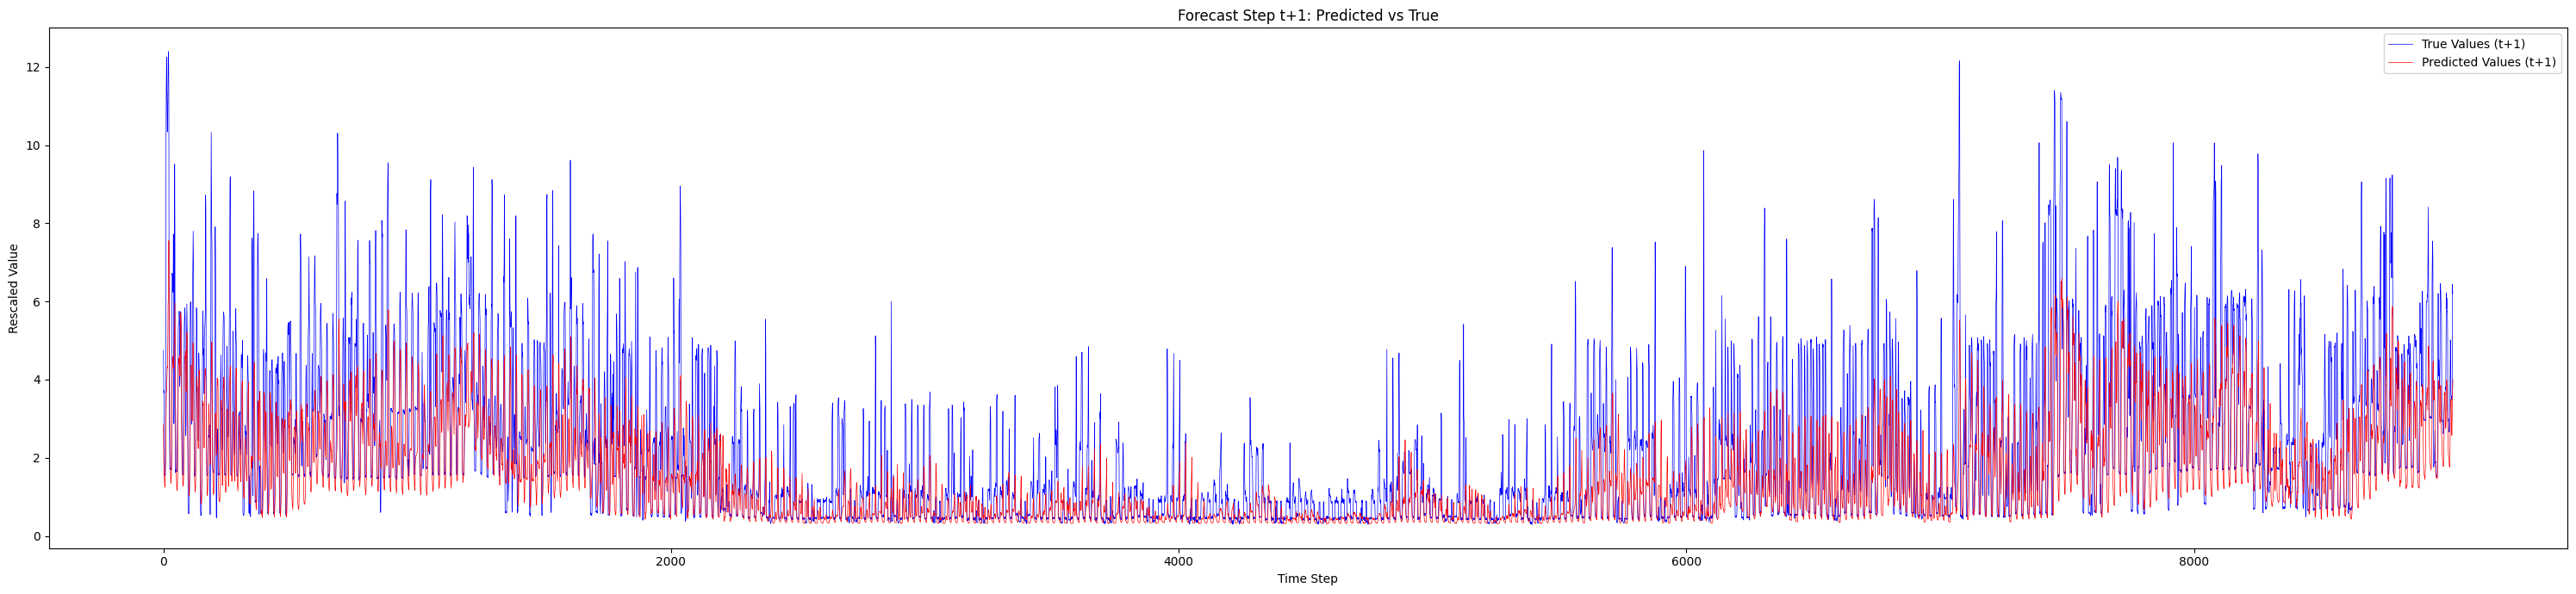



🔍 Training with m=288, n=6, horizon=6...
📥 Loading and preprocessing data...
🔢 Scaling values...
🧩 Constructing input sequences...
✅ Dataset sizes → Train: 17982, Val: 2997, Test: 8991
🧠 Initializing DIRNN model...
🚂 Starting full DI-RNN training...
Train target shape: torch.Size([17982, 6])
Train pred shape:   torch.Size([17982, 6])

🧠 Training s_rnn...
⏹️ Early stopping s_rnn at epoch 19. Best Val Loss: 0.144003.148258
🧠 Training p_rnn...
⏹️ Early stopping p_rnn at epoch 15. Best Val Loss: 0.140612.170532
🧠 Training bpnn...
⏹️ Early stopping bpnn at epoch 16. Best Val Loss: 0.144649.147062
 Shapes: (8991, 6), (8991, 6)

📊 Evaluation Metrics:
✅ MAE:  1.2046
✅ MSE:  2.9643
✅ MAPE: 0.8509
7.4660735 0.18375


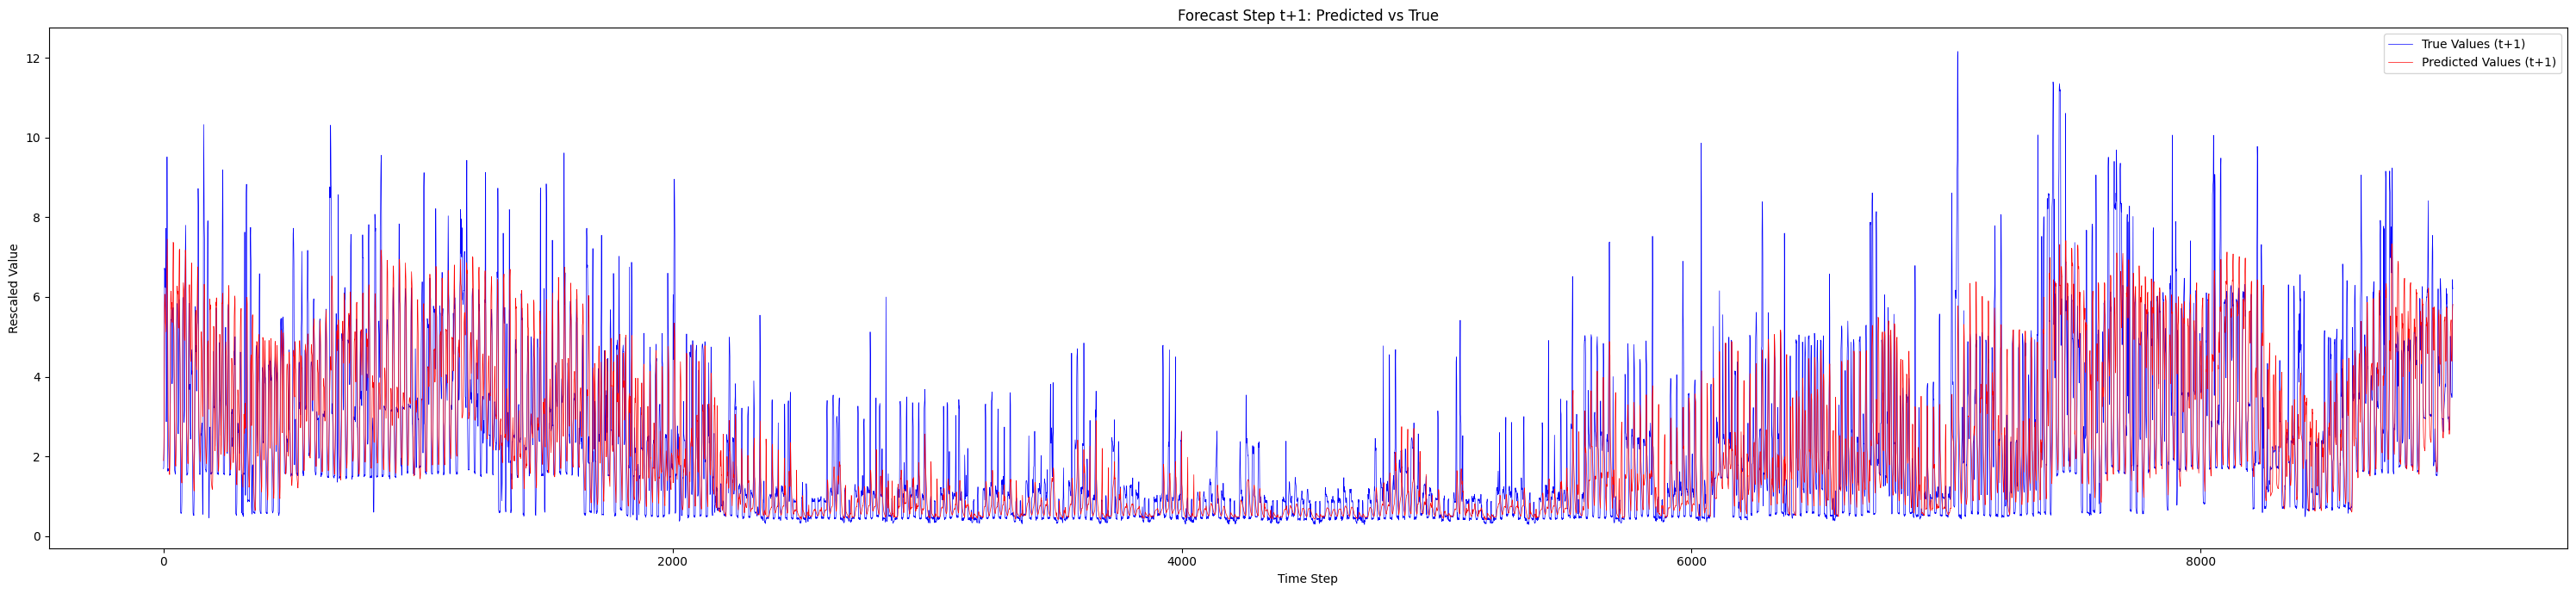



🔍 Training with m=384, n=8, horizon=6...
📥 Loading and preprocessing data...
🔢 Scaling values...
🧩 Constructing input sequences...
✅ Dataset sizes → Train: 17924, Val: 2987, Test: 8963
🧠 Initializing DIRNN model...
🚂 Starting full DI-RNN training...
Train target shape: torch.Size([17924, 6])
Train pred shape:   torch.Size([17924, 6])

🧠 Training s_rnn...
⏹️ Early stopping s_rnn at epoch 19. Best Val Loss: 0.145492.151873
🧠 Training p_rnn...
⏹️ Early stopping p_rnn at epoch 15. Best Val Loss: 0.147930.161916
🧠 Training bpnn...
⏹️ Early stopping bpnn at epoch 14. Best Val Loss: 0.151037.153669
 Shapes: (8963, 6), (8963, 6)

📊 Evaluation Metrics:
✅ MAE:  1.2296
✅ MSE:  3.1147
✅ MAPE: 0.8238
3.9980085 0.2851116


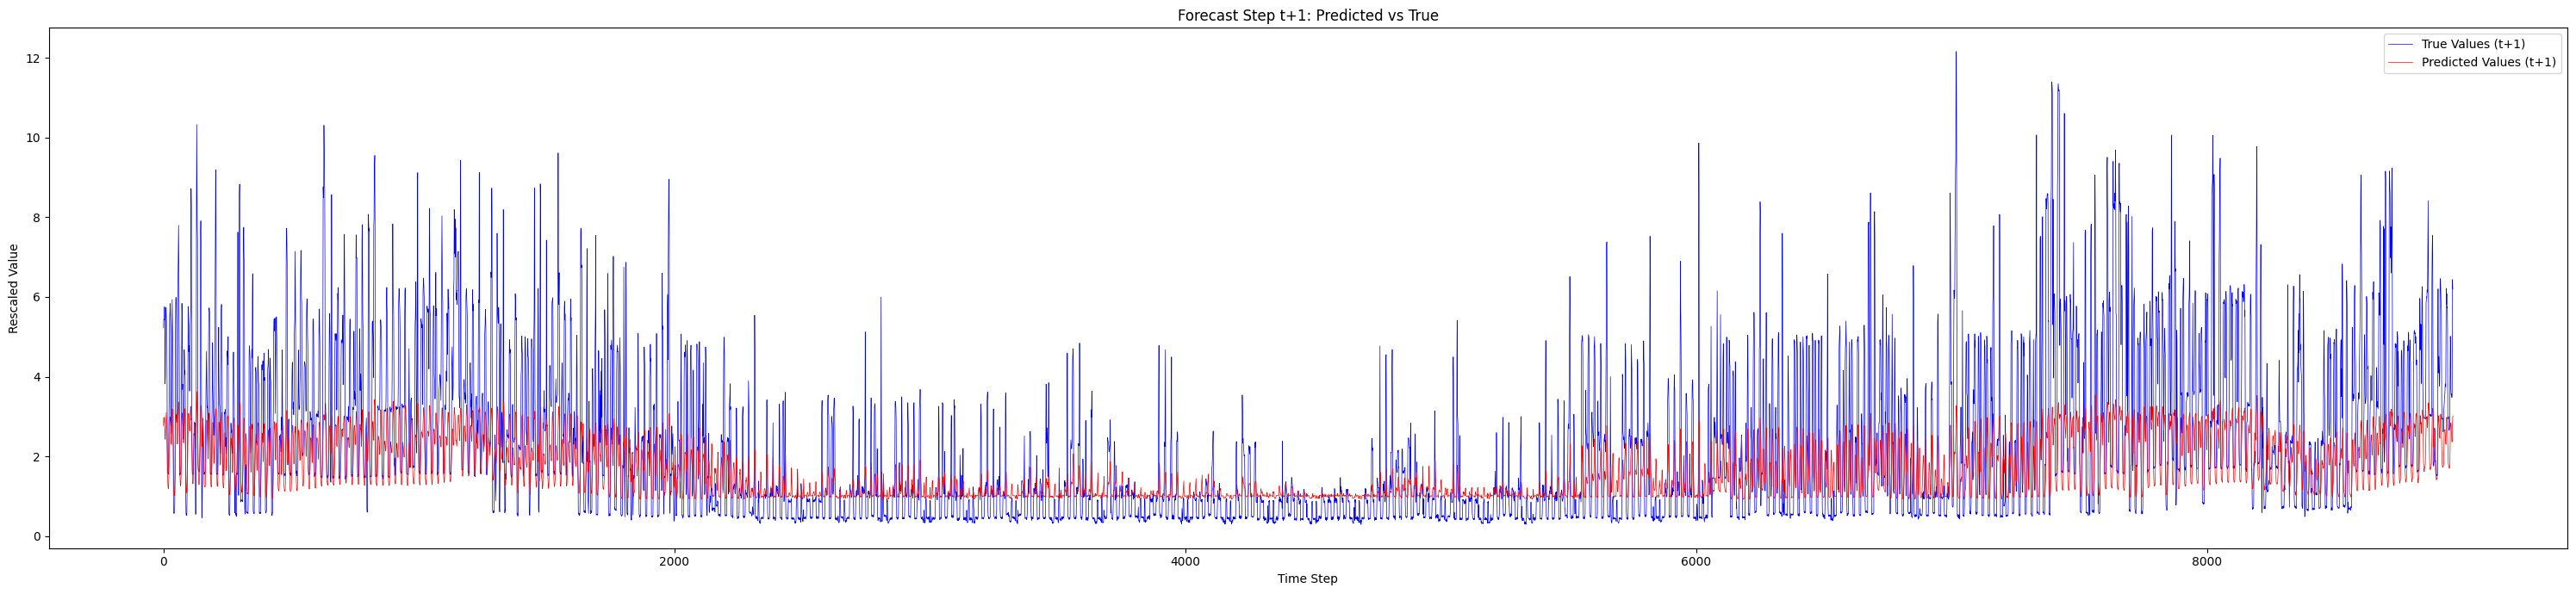

In [ ]:
for m, n in samples:
    print(f"\n\n🔍 Training with m={m}, n={n}, horizon={horizon}...")
    data, scaler, _ = preprocess_data('mm79158.csv', m, n, horizon=horizon, freq='1h')
    train_data = data['train']
    val_data = data['val']
    test_data = data['test']

    print("🧠 Initializing DIRNN model...")
    model = DIRNN(seq_input_size=1, per_input_size=1, hidden_size=64, bp_hidden_size=128, dropout=0.2, horizon=horizon)
    train_dirnn(model, train_data, val_data, epochs=100, lr_rnn=0.005, lr_bpnn=0.008, patience=3, device=device, min_epochs = 10)

    torch.save(model, f"models/dirnn_model_{m}_{n}.pth")

    model.eval()

    X_seq_test, X_per_test, y_test = test_data
    X_seq_test = torch.tensor(X_seq_test, dtype=torch.float32).to(device)
    X_per_test = torch.tensor(X_per_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

    preds = []

    with torch.no_grad():
        for i in range(0, len(X_seq_test)):
            seq_x = X_seq_test[i].unsqueeze(0).to(device)  # [1, m, 1]
            per_x = X_per_test[i].unsqueeze(0).to(device)  # [1, n, 1]

            pred = model(seq_x, per_x).squeeze(0)
            preds.append(pred)

    preds = preds = torch.stack(preds).cpu().numpy()  # [samples, horizon]
    true_vals = y_test.cpu().numpy()  # [samples, horizon]

    # Rescale to original units
    preds_rescaled = scaler.inverse_transform(preds)
    true_rescaled = scaler.inverse_transform(true_vals)

    print(f"\n Shapes: {preds_rescaled.shape}, {true_rescaled.shape}")

    mae = mean_absolute_error(true_rescaled.flatten(), preds_rescaled.flatten())
    mse = mean_squared_error(true_rescaled.flatten(), preds_rescaled.flatten())
    mape = mean_absolute_percentage_error(true_rescaled.flatten(), preds_rescaled.flatten())

    print("\n📊 Evaluation Metrics:")
    print(f"✅ MAE:  {mae:.4f}")
    print(f"✅ MSE:  {mse:.4f}")
    print(f"✅ MAPE: {mape:.4f}")

    print(preds_rescaled.max(), preds_rescaled.min())

    pred_step1 = preds_rescaled[:, 0]
    true_step1 = true_rescaled[:, 0]

    # Now plot 1:1 aligned forecast
    plt.figure(figsize=(30, 7))
    plt.plot(true_step1, color='blue', linewidth=0.5, label='True Values (t+1)')
    plt.plot(pred_step1, color='red', linewidth=0.5, label='Predicted Values (t+1)')
    plt.title("Forecast Step t+1: Predicted vs True")
    plt.xlabel("Time Step")
    plt.ylabel("Rescaled Value")
    plt.legend()
    plt.tight_layout()
    plt.show()
    

In [156]:
def horizon_rolling_forecast_dirnn(model, df_all, scaler, start_time, m, n, freq, forecast_horizon, total_steps, device='cpu'):
    model.eval()
    preds = []
    predicted_values = {}  # timestamp → predicted scaled value
    current_time = start_time
    step_size = pd.to_timedelta(freq)

    with torch.no_grad():
        steps_done = 0
        while steps_done < total_steps:
            horizon = min(forecast_horizon, total_steps - steps_done)
            serial_inputs = []
            periodic_inputs = []

            for h in range(horizon):
                now = current_time + h * step_size
                all_valid = True

                # --- Serial Input ---
                s_range = pd.date_range(end=now, periods=m, freq=freq)
                s_vals = []
                for ts in s_range:
                    if ts in predicted_values:
                        s_vals.append(predicted_values[ts])
                    elif ts in df_all.index:
                        s_vals.append(df_all.loc[ts, 'scaled'])
                    else:
                        all_valid = False
                        break

                if len(s_vals) < m:
                    all_valid = False

                # --- Periodic Input ---
                p_vals = []
                for i in range(1, n + 1):
                    prev_day = now - pd.Timedelta(days=i)
                    if prev_day in predicted_values:
                        p_vals.append(predicted_values[prev_day])
                    elif prev_day in df_all.index:
                        p_vals.append(df_all.loc[prev_day, 'scaled'])
                    else:
                        all_valid = False
                        break

                if len(p_vals) < n:
                    all_valid = False

                # Only append if both are valid
                if all_valid:
                    serial_inputs.append(np.array(s_vals).reshape(m, 1))
                    periodic_inputs.append(np.array(p_vals).reshape(n, 1))
                else:
                    break

            if len(serial_inputs) < horizon or len(periodic_inputs) < horizon:
                print("⚠️ Not enough context to continue prediction. Stopping early.", flush=True)
                break

            # Convert to tensors
            x_seq = torch.tensor(serial_inputs[-1], dtype=torch.float32).unsqueeze(0).to(device)  # [1, m, 1]
            x_per = torch.tensor(periodic_inputs[-1], dtype=torch.float32).unsqueeze(0).to(device)  # [1, n, 1]


            # Predict
            y_scaled = model(x_seq, x_per).cpu().numpy()  # [horizon]

            # Save predictions and update state
            for h in range(horizon):
                ts = current_time + h * step_size
                pred_val = float(y_scaled[0, h])  # ✅ Access from batch 0, horizon h
                predicted_values[ts] = pred_val
                preds.append(pred_val)



            steps_done += horizon
            current_time += horizon * step_size

            print(f"✅ Forecasted {steps_done}/{total_steps} steps", flush=True)

    preds = np.array(preds).reshape(-1, 1)
    print("Scaled preds: max =", preds.max(), ", min =", preds.min(), flush=True)
    return scaler.inverse_transform(preds).flatten()


In [150]:
model = torch.load("models/dirnn_model_96_2.pth", map_location=device)

C:\Users\janav\AppData\Local\Temp\ipykernel_24980\1449945831.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("models/dirnn_model_96_2.pth", map_locati

In [165]:
# Parameters
csv_path = 'mm79158.csv'
m = 96  # serial input length
n = 2   # periodic inputs from previous days
horizon = 6
freq = '1h'

# Preprocess
data, scaler, df_all = preprocess_data(csv_path, m=m, n=n, horizon=horizon, freq=freq)
test_data = data['test']

# Use the last timestamp from val to start forecasting into test
val_end_idx = int(len(df_all) * 0.7) - 1  # 60% train + 10% val = 70%
start_time = df_all.index[val_end_idx + 1]

# Total steps to forecast: full test target length
total_steps = test_data[2].shape[0]

# Run rolling forecast using the updated method
y_pred = horizon_rolling_forecast_dirnn(
    model=model,
    df_all=df_all,
    start_time=start_time,
    total_steps=total_steps,
    forecast_horizon=horizon,
    m=m,
    n=n,
    freq=freq,
    scaler=scaler,
    device='cpu'
)


📥 Loading and preprocessing data...
🔢 Scaling values...
🧩 Constructing input sequences...
✅ Dataset sizes → Train: 18097, Val: 3016, Test: 9049
✅ Forecasted 6/9049 steps
✅ Forecasted 12/9049 steps
✅ Forecasted 18/9049 steps
✅ Forecasted 24/9049 steps
✅ Forecasted 30/9049 steps
✅ Forecasted 36/9049 steps
✅ Forecasted 42/9049 steps
✅ Forecasted 48/9049 steps
✅ Forecasted 54/9049 steps
✅ Forecasted 60/9049 steps
✅ Forecasted 66/9049 steps
✅ Forecasted 72/9049 steps
✅ Forecasted 78/9049 steps
✅ Forecasted 84/9049 steps
✅ Forecasted 90/9049 steps
✅ Forecasted 96/9049 steps
✅ Forecasted 102/9049 steps
✅ Forecasted 108/9049 steps
✅ Forecasted 114/9049 steps
✅ Forecasted 120/9049 steps
✅ Forecasted 126/9049 steps
✅ Forecasted 132/9049 steps
✅ Forecasted 138/9049 steps
✅ Forecasted 144/9049 steps
✅ Forecasted 150/9049 steps
✅ Forecasted 156/9049 steps
✅ Forecasted 162/9049 steps
✅ Forecasted 168/9049 steps
✅ Forecasted 174/9049 steps
✅ Forecasted 180/9049 steps
✅ Forecasted 186/9049 steps
✅ For

In [166]:
# Use the full flattened test target sequence (assuming rolling forecast from a single input)
y_test_flat = y_test.flatten()[:len(y_pred)]  # Crop to match y_pred length
y_true = scaler.inverse_transform(y_test_flat.reshape(-1, 1)).flatten()

# y_pred is already inverse-transformed in horizon_rolling_forecast_dirnn
y_pred = y_pred.flatten()

print("y_pred (range):", (y_pred.min(), y_pred.max()))
print("y_true (range):", (y_true.min(), y_true.max()))

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print("\n📊 Metrics:")
print(f"✅ MAE:  {mae:.4f}")
print(f"✅ MSE:  {mse:.4f}")
print(f"✅ MAPE: {mape:.4f}")


y_pred (range): (0.18375, 4.427483495844305)
y_true (range): (0.376875, 12.394375)

📊 Metrics:
✅ MAE:  2.7979
✅ MSE:  11.8399
✅ MAPE: 0.8567


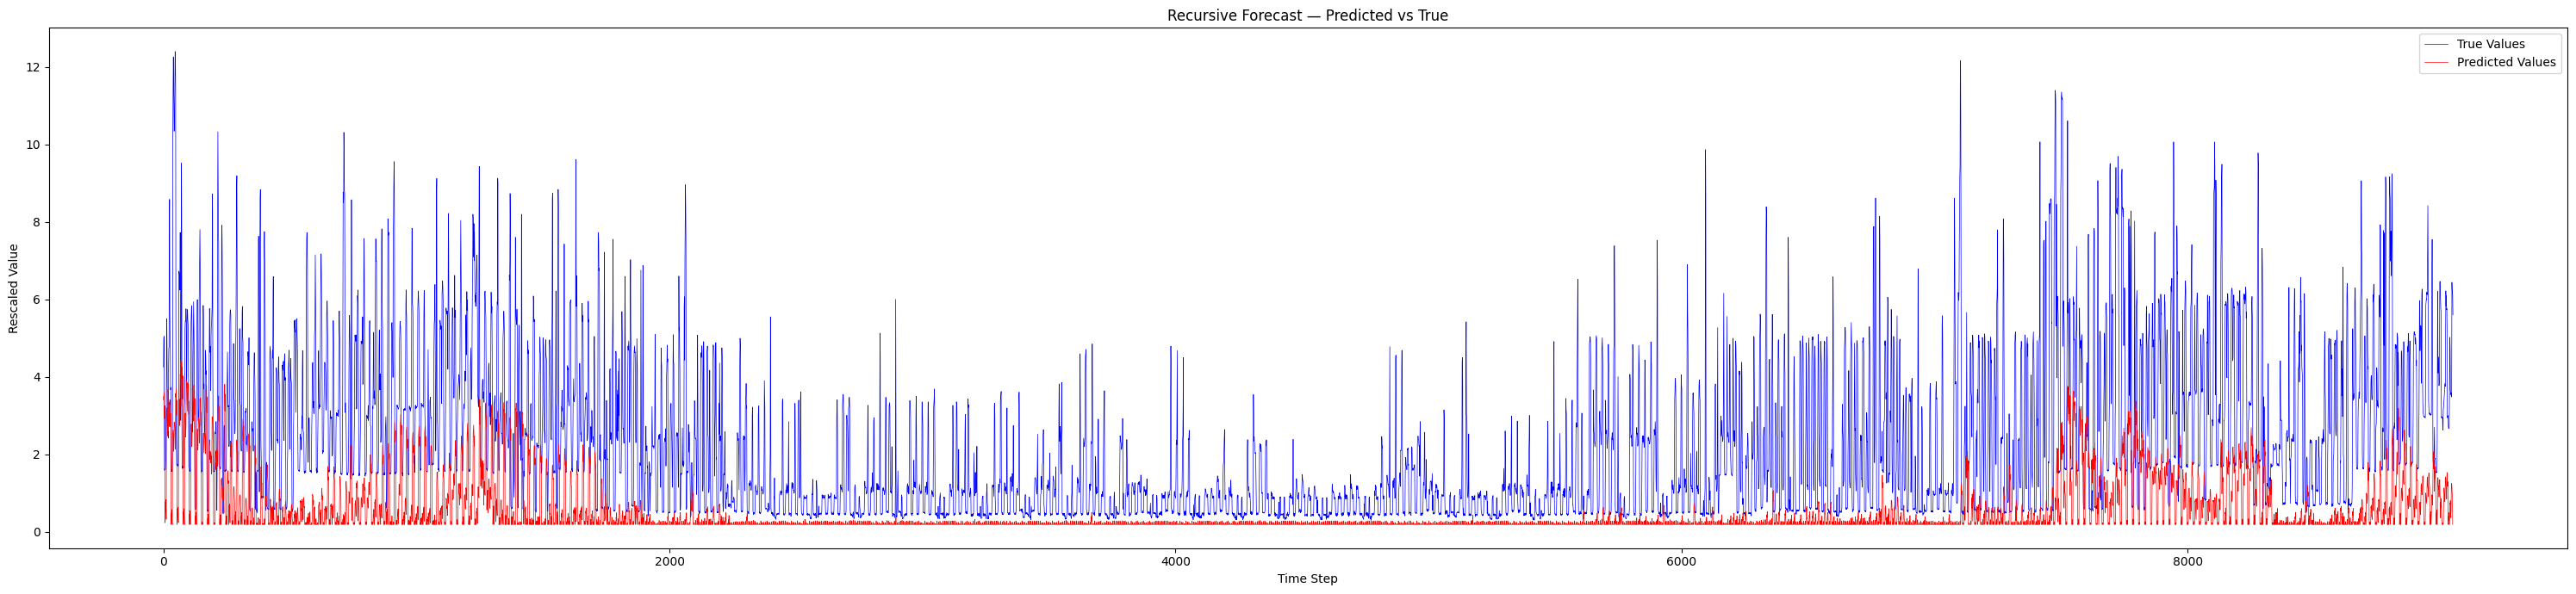

In [167]:
plt.figure(figsize=(30, 7))
plt.plot(true, color='blue', linewidth=0.5, label='True Values')
plt.plot(y_pred, color='red', linewidth=0.5, label='Predicted Values')
plt.title("Recursive Forecast — Predicted vs True")
plt.xlabel("Time Step")
plt.ylabel("Rescaled Value")
plt.legend()
plt.tight_layout()
plt.show()
